# A file where we harmonise

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
# --- Model definition (same as training) ------------------------------
class SmallCNN(nn.Module):
    def __init__(self, in_ch=1, n_classes=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 25×25
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 12×12
        )
        self.fc = nn.Linear(32 * 12 * 12, n_classes)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


C:\Users\joche\AppData\Local\Temp\ipykernel_13996\1801421618.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/small_cnn.pth", map

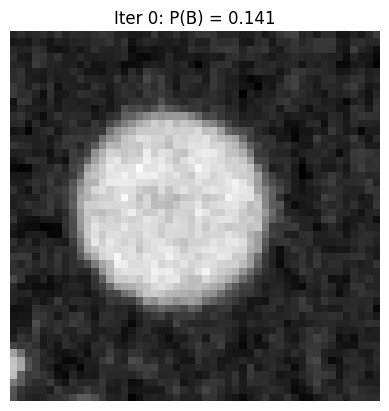

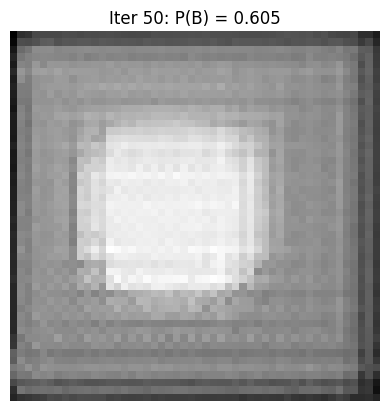

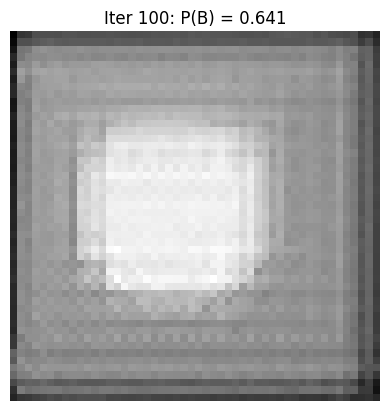

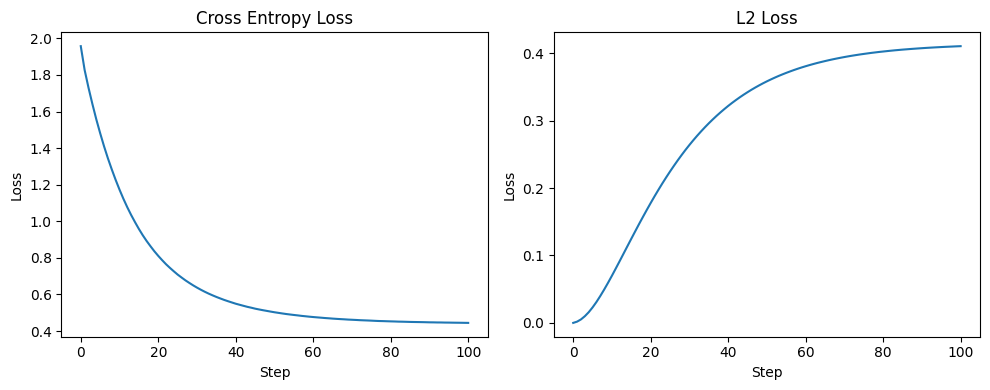

In [ ]:

# --- Load classifier -----------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN().to(device)
model.load_state_dict(torch.load("models/small_cnn.pth", map_location=device))
model.eval()

# --- Load an example image patch (class A) -------------------------
# Replace path if needed
A = np.load("data/augmented_images_algoA.npy")  # shape (N,50,50)
x0_np = A[0]                  # pick first sample
x0 = torch.from_numpy(x0_np).unsqueeze(0).unsqueeze(0).float() / 255.0  # (1,1,50,50)
x0 = x0.to(device)

# --- Optimization setup --------------------------------------------
target_label = torch.tensor([1], device=device)  # want class B
lambda_l2 = 20
lr = 0.001
n_steps = 100
record_iters = [0, n_steps//2, n_steps]  # initial, mid, final

# prepare variable
x = x0.clone().detach().requires_grad_(True)

# records
records = []
ce_history = []  # Track cross entropy loss
l2_history = []  # Track L2 loss
step_history = []  # Track steps

for step in range(n_steps + 1):
    logits = model(x)
    ce = F.cross_entropy(logits, target_label)
    l2 = lambda_l2 * torch.norm(x - x0)**2
    loss = ce + l2
    
    # record losses at each step
    ce_history.append(ce.item())
    l2_history.append(l2.item())
    step_history.append(step)

    # record if needed
    if step in record_iters:
        probs = F.softmax(logits, dim=1)[0,1].item()  # P(class B)
        records.append((step, x.detach().cpu().squeeze().numpy(), probs))

    # gradient step (skip update at final record)
    if step < n_steps:
        loss.backward()
        with torch.no_grad():
            x.data -= lr * x.grad.data
            x.data.clamp_(0, 1)
        x.grad.zero_()

# --- Plot results ----------------------------------------------------
for step, img, score in records:
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f"Iter {step}: P(B) = {score:.3f}")
    plt.axis('off')

# Plot losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(step_history, ce_history)
plt.title('Cross Entropy Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(step_history, l2_history)
plt.title('L2 Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()
